# Dyna-Q 算法

教程链接：[Dyna-Q 算法](https://hrl.boyuai.com/chapter/1/dyna-q%E7%AE%97%E6%B3%95)

在强化学习中，“模型”通常指与智能体交互的环境模型，即对环境的状态转移概率和奖励函数进行建模。根据是否具有环境模型，强化学习算法分为两种：基于模型的强化学习（model-based reinforcement learning）和无模型的强化学习（model-free reinforcement learning）。
- 无模型的强化学习根据智能体与环境交互采样到的数据直接进行策略提升或者价值估计，如两种时序差分算法，即 Sarsa 和 Q-learning 算法，便是两种无模型的强化学习方法。
- 在基于模型的强化学习中，模型可以是事先知道的，也可以是根据智能体与环境交互采样到的数据学习得到的，然后用这个模型帮助策略提升或者价值估计。两种动态规划算法，即策略迭代和价值迭代，则是基于模型的强化学习方法，在这两种算法中环境模型是事先已知的。 Dyna-Q 算法也是非常基础的基于模型的强化学习算法，不过它的环境模型是通过采样数据估计得到的。

Dyna-Q 使用一种叫做 Q-planning 的方法来基于模型生成一些模拟数据，然后用模拟数据和真实数据一起改进策略。Q-planning 每次选取一个曾经访问过的状态$s$，采取一个曾经在该状态下执行过的动作$a$，通过模型得到转移后的状态$s^\prime$以及奖励$r$，并根据这个模拟数据$(s,a,r,s^\prime)$，用 Q-learning 的更新方式来更新动作价值函数。

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import random
import time
from typing import Tuple


class CliffWalkingEnv:
    def __init__(self, ncol:int, nrow:int):
        self.nrow = nrow
        self.ncol = ncol
        self.x = 0  # 记录当前智能体位置的横坐标
        self.y = self.nrow - 1  # 记录当前智能体位置的纵坐标

    def step(self, action:int) -> Tuple[int, int, bool]:  # 外部调用这个函数来改变当前位置
        # 4种动作, change[0]:上, change[1]:下, change[2]:左, change[3]:右。坐标系原点(0,0)
        # 定义在左上角
        change = [[0, -1], [0, 1], [-1, 0], [1, 0]]
        self.x = min(self.ncol - 1, max(0, self.x + change[action][0]))
        self.y = min(self.nrow - 1, max(0, self.y + change[action][1]))
        next_state = self.y * self.ncol + self.x
        reward = -1
        done = False
        if self.y == self.nrow - 1 and self.x > 0:  # 下一个位置在悬崖或者目标
            done = True
            if self.x != self.ncol - 1:
                reward = -100
        return next_state, reward, done

    def reset(self) -> int:  # 回归初始状态,起点在左上角
        self.x = 0
        self.y = self.nrow - 1
        return self.y * self.ncol + self.x

In [2]:
class Policy:
    """算法基类"""
    def __init__(self, ncol:int, nrow:int, epsilon:float, alpha:float, gamma:float, n_action:int=4):
        self.Q_table = np.zeros([nrow * ncol, n_action])  # 初始化Q(s,a)表格
        self.n_action = n_action  # 动作个数
        self.alpha = alpha  # 学习率
        self.gamma = gamma  # 折扣因子
        self.epsilon = epsilon  # epsilon-贪婪策略中的参数

    def take_action(self, state:int) -> int:  # 选取下一步的操作,具体实现为epsilon-贪婪
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.n_action)
        else:
            action = np.argmax(self.Q_table[state])
        return action

    def best_action(self, state:int) -> int:  # 用于打印策略
        Q_max = np.max(self.Q_table[state])
        a = [0 for _ in range(self.n_action)]
        for i in range(self.n_action):  # 若两个动作的价值一样,都会记录下来
            if self.Q_table[state, i] == Q_max:
                a[i] = 1
        return a

    def update(self, *args, **argv):
        raise NotImplementedError

In [3]:
class DynaQ(Policy):
    """ Dyna-Q算法 """
    def __init__(self, 
                 ncol:int,
                 nrow:int,
                 epsilon:float,
                 alpha:float,
                 gamma:float,
                 n_planning:int,
                 n_action:int=4):
        super().__init__(ncol, nrow, epsilon, alpha, gamma, n_action)

        self.n_planning = n_planning  #执行Q-planning的次数, 对应1次Q-learning
        self.model = dict()  # 环境模型

    def q_learning(self, s0:int, a0:int, r:float, s1:int):
        td_error = r + self.gamma * self.Q_table[s1].max(
        ) - self.Q_table[s0, a0]
        self.Q_table[s0, a0] += self.alpha * td_error

    def update(self, s0:int, a0:int, r:float, s1:int):
        self.q_learning(s0, a0, r, s1)
        self.model[(s0, a0)] = r, s1  # 将数据添加到模型中
        for _ in range(self.n_planning):  # Q-planning循环
            # 随机选择曾经遇到过的状态动作对
            (s, a), (r, s_) = random.choice(list(self.model.items()))
            self.q_learning(s, a, r, s_)

In [4]:
def DynaQ_CliffWalking(n_planning:int) -> list:
    ncol = 12
    nrow = 4
    env = CliffWalkingEnv(ncol, nrow)
    epsilon = 0.01
    alpha = 0.1
    gamma = 0.9
    agent = DynaQ(ncol, nrow, epsilon, alpha, gamma, n_planning)
    num_episodes = 300  # 智能体在环境中运行多少条序列

    return_list = []  # 记录每一条序列的回报
    for i in range(10):  # 显示10个进度条
        # tqdm的进度条功能
        with tqdm(total=int(num_episodes / 10),
                  desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes / 10)):  # 每个进度条的序列数
                episode_return = 0
                state = env.reset()
                done = False
                while not done:
                    action = agent.take_action(state)
                    next_state, reward, done = env.step(action)
                    episode_return += reward  # 这里回报的计算不进行折扣因子衰减
                    agent.update(state, action, reward, next_state)
                    state = next_state
                return_list.append(episode_return)
                if (i_episode + 1) % 10 == 0:  # 每10条序列打印一下这10条序列的平均回报
                    pbar.set_postfix({
                        'episode':
                        '%d' % (num_episodes / 10 * i + i_episode + 1),
                        'return':
                        '%.3f' % np.mean(return_list[-10:])
                    })
                pbar.update(1)
    return return_list

Q-planning步数为：0


Iteration 9: 100%|██████████| 30/30 [00:00<00:00, 4824.55it/s, episode=300, return=-16.500]


Q-planning步数为：2


Iteration 9: 100%|██████████| 30/30 [00:00<00:00, 2072.11it/s, episode=300, return=-13.500]


Q-planning步数为：20


Iteration 9: 100%|██████████| 30/30 [00:00<00:00, 487.55it/s, episode=300, return=-13.400]


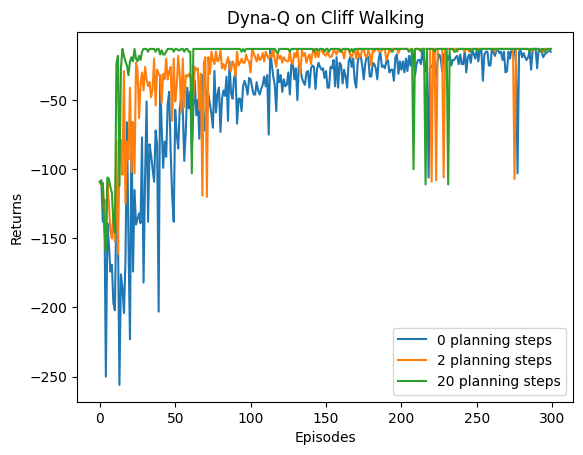

In [5]:
np.random.seed(0)
random.seed(0)
n_planning_list = [0, 2, 20]
for n_planning in n_planning_list:
    print('Q-planning步数为：%d' % n_planning)
    time.sleep(0.5)
    return_list = DynaQ_CliffWalking(n_planning)
    episodes_list = list(range(len(return_list)))
    plt.plot(episodes_list,
             return_list,
             label=str(n_planning) + ' planning steps')
plt.legend()
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Dyna-Q on {}'.format('Cliff Walking'))
plt.show()

随着 Q-planning 步数的增多，Dyna-Q 算法的收敛速度也随之变快。当然，并不是在所有的环境中，都是 Q-planning 步数越大则算法收敛越快，这取决于环境是否是确定性的，以及环境模型的精度。在上述悬崖漫步环境中，状态的转移是完全确定性的，构建的环境模型的精度是最高的，所以可以通过增加 Q-planning 步数来直接降低算法的样本复杂度。